# Get data

In [851]:
import torch, numpy as np, matplotlib.pyplot as plt, seaborn as sns

In [852]:
names = open("names.txt").read().splitlines()
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

# Create dataset

In [853]:
context = 3

In [854]:
import pdb

ds = []
for name in names:
    n = '.'*context + name + '.'
    tuples = list(zip(*list(n[i:] for i in range(context + 1))))
    ds.extend(list(map(lambda tup: (tup[0:context], tup[context]), tuples)))

ds[:15]

[(('.', '.', '.'), 'e'),
 (('.', '.', 'e'), 'm'),
 (('.', 'e', 'm'), 'm'),
 (('e', 'm', 'm'), 'a'),
 (('m', 'm', 'a'), '.'),
 (('.', '.', '.'), 'o'),
 (('.', '.', 'o'), 'l'),
 (('.', 'o', 'l'), 'i'),
 (('o', 'l', 'i'), 'v'),
 (('l', 'i', 'v'), 'i'),
 (('i', 'v', 'i'), 'a'),
 (('v', 'i', 'a'), '.'),
 (('.', '.', '.'), 'a'),
 (('.', '.', 'a'), 'v'),
 (('.', 'a', 'v'), 'a')]

# Vocab

In [855]:
vocab = sorted(set('.'.join(names)))
vocab

['.',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [856]:
ctoi = {c: i for i, c in enumerate(vocab)}
itoc = {i: c for c, i in ctoi.items() }

# Embedding

In [857]:
emb_dims = 10
E = torch.randn(len(vocab), emb_dims)
E.shape

torch.Size([27, 10])

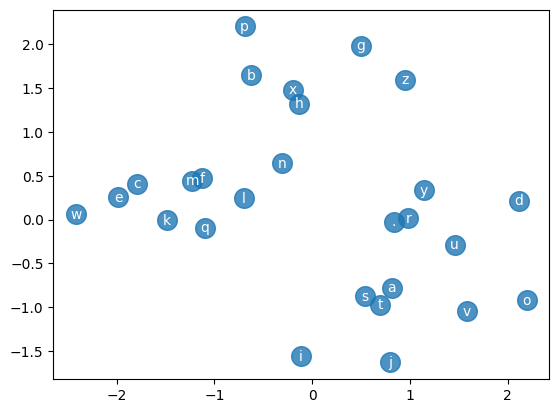

In [858]:
def vis_emb():
    cp = E.detach().numpy()
    plt.scatter(cp[:, 0], cp[:, 1], s=200, alpha=0.8)

    for char in vocab:
        i = ctoi[char]
        plt.text(cp[i, 0], cp[i, 1], char, va="center", ha="center", color="white")

vis_emb()

In [859]:
ids = torch.zeros(len(ds), context + 1, dtype=torch.int)
for i, (x, y) in enumerate(ds):
    ids[i, 0:context] = torch.tensor(list(map(lambda c: ctoi[c],x)))
    ids[i, context] = ctoi[y]

ids[:10]

tensor([[ 0,  0,  0,  5],
        [ 0,  0,  5, 13],
        [ 0,  5, 13, 13],
        [ 5, 13, 13,  1],
        [13, 13,  1,  0],
        [ 0,  0,  0, 15],
        [ 0,  0, 15, 12],
        [ 0, 15, 12,  9],
        [15, 12,  9, 22],
        [12,  9, 22,  9]], dtype=torch.int32)

# Initialization

In [878]:
nh = 200
Wh = torch.randn(context*emb_dims, nh)
Bh = torch.zeros(nh)

no = len(vocab)
Wo = torch.randn(nh, no) * 0.1 
Bo = torch.zeros(no)



params = [E, Wh, Bh, Wo, Bo]
for  param in params: param.requires_grad_()

In [879]:
import torch.nn.functional as F

In [880]:
ods = F.one_hot(ids.long(), 27)
ods.shape

torch.Size([228146, 4, 27])

In [881]:
ntr = int(len(ods) * 0.8)
nval = int(len(ods) * 0.9)
idx = torch.randint(0, len(ods), (len(ods),))

tr_ds = ods[idx[:ntr]]
val_ds = ods[idx[ntr:nval]]
test_ds = ods[idx[nval:]]

assert sum(list(map(len, [tr_ds, val_ds, test_ds]))) == len(ods)

# Training

In [882]:
def get_batches(bs, ds):
    b = ds[torch.randint(0, len(ds), size=(bs,))].float()

    xb = b[:, 0:context]
    yb = b[:, context]

    return xb, yb

In [883]:
def forward(bs, xb):
    ae = (xb @ E).view(bs, -1)
    ah = (ae @ Wh + Bh).tanh()
    ao = ah @ Wo + Bo
    
    return ao

In [884]:
def optimize(lr):
    for param in params:
        param.data -= param.grad * lr
        param.grad = None

In [885]:
tr_losses = []
val_losses = []

In [894]:
bs = 128*8
itr = 30000*3
rfq = 1000


for i in range(itr):
    # Train
    xb, yb = get_batches(bs, tr_ds)
    z = forward(bs, xb)
    tr_loss = F.cross_entropy(z, yb)
    tr_loss.backward()
    optimize(0.01)

    
    # Eval
    if i % rfq == 0: 
        val_bs = len(val_ds)
        xb, yb = get_batches(val_bs, val_ds)
        with torch.no_grad(): 
            z = forward(val_bs, xb)
            val_loss = F.cross_entropy(z, yb)

        # Report
        print(f"Tr: {tr_loss:.2f} | Val: {val_loss:.2f}")
        tr_losses.append(tr_loss.item())
        val_losses.append(val_loss.item())

Tr: 2.09 | Val: 2.17
Tr: 2.06 | Val: 2.15
Tr: 2.13 | Val: 2.17
Tr: 2.16 | Val: 2.16
Tr: 2.08 | Val: 2.17
Tr: 2.14 | Val: 2.17
Tr: 2.02 | Val: 2.16
Tr: 2.06 | Val: 2.16
Tr: 2.10 | Val: 2.17
Tr: 2.08 | Val: 2.18
Tr: 2.07 | Val: 2.15
Tr: 2.09 | Val: 2.16
Tr: 2.07 | Val: 2.17
Tr: 2.12 | Val: 2.17
Tr: 2.05 | Val: 2.16
Tr: 2.06 | Val: 2.16
Tr: 2.12 | Val: 2.16
Tr: 2.10 | Val: 2.16
Tr: 2.13 | Val: 2.16
Tr: 2.10 | Val: 2.16
Tr: 2.18 | Val: 2.17
Tr: 2.11 | Val: 2.16
Tr: 2.08 | Val: 2.16
Tr: 2.09 | Val: 2.16
Tr: 2.05 | Val: 2.17
Tr: 2.04 | Val: 2.16
Tr: 2.06 | Val: 2.17
Tr: 2.08 | Val: 2.16
Tr: 2.12 | Val: 2.16
Tr: 2.20 | Val: 2.15
Tr: 2.14 | Val: 2.18
Tr: 2.23 | Val: 2.16
Tr: 2.12 | Val: 2.16
Tr: 2.12 | Val: 2.17
Tr: 2.04 | Val: 2.17
Tr: 2.16 | Val: 2.16
Tr: 2.05 | Val: 2.15
Tr: 2.06 | Val: 2.17
Tr: 1.99 | Val: 2.16
Tr: 2.08 | Val: 2.15
Tr: 2.13 | Val: 2.15
Tr: 2.14 | Val: 2.17
Tr: 2.09 | Val: 2.16
Tr: 2.14 | Val: 2.16
Tr: 2.13 | Val: 2.15
Tr: 2.10 | Val: 2.15
Tr: 2.01 | Val: 2.16
Tr: 2.09 | Va

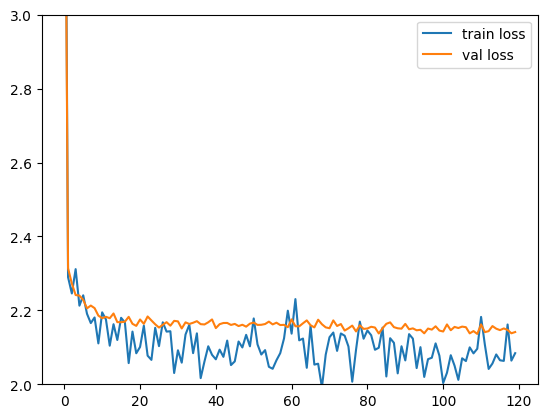

In [895]:
x = np.arange(0, len(tr_losses))
l1, l2 = plt.plot(x, tr_losses, x, val_losses)
plt.ylim(2,3)
l1.set_label("train loss")
l2.set_label("val loss")

plt.legend()


In [896]:
bs = len(test_ds)
x_test, y_test = get_batches(bs, test_ds)

print(f"Test loss is {F.cross_entropy(forward(bs, x_test), y_test):.2f}")

Test loss is 2.13


In [897]:
gen = []

for i in range(20):
    res = []
    input = torch.tensor(list(map(int, context*'0')))

    while True:
        z = forward(1, F.one_hot(input, len(vocab)).float())
        predi = torch.multinomial(F.softmax(z, dim=1), 1).squeeze()
        predc = itoc[predi.item()]

        if predc == '.': break

        res.append(predc)
        input = torch.concat([input[1:], predi[None]])

    gen.append(''.join(res))

gen

['roy',
 'ree',
 'steya',
 'khitzen',
 'iyvanna',
 'keniyn',
 'abatraalin',
 'brine',
 'holleodon',
 'jesci',
 'brentlonnelynn',
 'samaralyn',
 'srimayt',
 'remils',
 'rebwenecdin',
 'jawy',
 'vallinley',
 'roshiko',
 'alwve',
 'zrolexane']